# Produzindo o modelo

Agora, vamos criar e treinar o nosso modelo de fato.

Vamos pegar os dados exportados na fase de análise

Vamos pegar a MLP desenvolvida

Vamos juntar tudo e fazer um modelo que reconhece comandos sonoros.

### Ler os dados coletados
e talvez realizar algum pré-processamento

In [1]:
import pandas as pd
import os
import subprocess
import pickle

from funcoes import arquivo_mais_recente, nome_diferente
from math import inf as infinito

# ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# pegar o CSV mais recente no diretório 'csv'
arquivo = arquivo_mais_recente('csv')
assert os.path.isfile(arquivo)

dataset = pd.read_csv(arquivo)

dataset.head()

,classe,f_centro_gravidade,f_fluxo_spectral,f_media
0,0,1746.282903,4.936092,0.052391
1,0,1794.379078,0.890205,0.069452
2,0,1695.063751,1.270188,0.047092
3,0,1746.265699,3.542589,0.056585
4,0,1787.310829,5.098251,0.050345


Para saber que número pertence a que classe:

In [2]:
raiz = 'dataset'

classes = os.listdir(raiz)

for i,classe in enumerate(classes):
    print("%d: %s" % (i, classe))

0: assobio_agudo
1: palmas
2: ruido_sedis
3: assobio_grave


### Dividindo os dados coletados em conjunto de treino e teste balanceados

In [3]:
# Que porcentagem dos dados vamos pegar para treino
fracao_treino = 0.7

dados_treino = pd.DataFrame()
dados_teste = pd.DataFrame()

for classe in dataset['classe'].unique():
    # só pegar dados dessa classe
    dados = dataset.loc[dataset['classe'] == classe]
    
    treino = dados.sample(frac=fracao_treino)
    teste = dados.drop(treino.index)
    
    dados_treino = dados_treino.append(treino)
    dados_teste = dados_teste.append(teste)


###  Normalizando e dividindo em features e target

In [4]:
"""
Treino
"""
# Pegando as respostas
labels_treino = dados_treino['classe'].as_matrix()
# Fazendo standardization: subtrai a média e divide pelo desvio padrão
dados_treino = (dados_treino - dados_treino.mean()) / dados_treino.std()
# Remove a coluna 'classe' e transforma em matriz
dados_treino = dados_treino.loc[:, dados_treino.columns != 'classe'].as_matrix()

"""
Teste
"""
# Pegando as respostas
labels_teste = dados_teste['classe'].as_matrix()
# Fazendo standardization: subtrai a média e divide pelo desvio padrão
dados_teste = (dados_teste - dados_teste.mean()) / dados_teste.std()
# Remove a coluna 'classe' e transforma em matriz
dados_teste = dados_teste.loc[:, dados_teste.columns != 'classe'].as_matrix()

### Configurando o modelo

In [5]:
# quantidade de neurônios na camada de entrada
tam_entrada = len(dados_treino[0])

# quantidade de neurônios na camada de saída
tam_saida = len(set(labels_treino))

# Quantos neurônios tem em cada camada (sem contar o bias)
formato_rede = [tam_entrada, tam_saida, tam_saida]

# Variação mínima do erro como critério de parada
delta_erro_minimo = 0.00001

# Número máximo de iterações
max_iteracoes = 10000

In [6]:
# atualizando o código dentro de MLP.py, que é extraído de MLP.ipynb
subprocess.Popen(['ipython', 'nbconvert', '--to=python', 'MLP.ipynb'])

from MLP import *

### Treinamento

In [7]:
rede = gerar_rede(formato_rede)

erro_anterior = infinito

for _ in range(max_iteracoes):
    erros = []

    for dado in range(len(dados_treino)):
        # Atualizar os pesos: joga dados[dado] na entrada, e propaga o erro
        # pra ajustar os pesos
        rede = forward_backward(rede, dados_treino[dado], one_hot(labels_treino[dado], tam_saida))

        # com os novos pesos, vamos ver o que ele prediz
        I, Y = forward(rede, dados_treino[dado])
        d = one_hot(labels_treino[dado], tam_saida)

        # vamos guardar o erro entre o que ele previu e o que é pra ser
        erros.append(erro_total(Y[-1], d))

    # erro médio
    erro = sum(erros)/len(erros)
    
    if _ == 0:
        print("erro inicial: ", erro)
        
    if _ % (max_iteracoes / 10) == 0:
        print("erro medio: ", erro)
        
    if abs(erro - erro_anterior) <= delta_erro_minimo:
        break
        
    erro_anterior = erro
        
print("\nerro final: ",erro)

erro inicial:  0.5435615750009661
erro medio:  0.5435615750009661

erro final:  0.0017355472399067393


### Testes

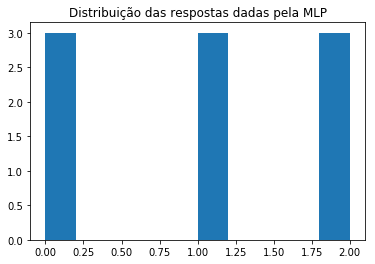

Acertou 100.0 %


In [8]:
certos = 0
errados = 0

resultados = []

for i in range(len(dados_teste)):
    # vamos ver o que ele prediz
    resultado = predizer(rede, dados_teste[i])
    resultados.append(resultado)
    if resultado == labels_teste[i]:
        certos +=1
    else:
        errados +=1

plt.hist(resultados)
plt.title("Distribuição das respostas dadas pela MLP")
plt.show()

print("Acertou %.1f %%" % (100*certos / (certos + errados)))



### Exportação do modelo para arquivo

Basta serializar a variável "rede" e gravar num arquivo.

In [9]:
diretorio = "rede"

if not os.path.exists(diretorio):
    os.makedirs(diretorio)
    
nome = nome_diferente("rede",diretorio, formato="pickle")

with open(nome, 'wb') as myf:
    myf.write(pickle.dumps(rede))